In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet

dir_parts = os.getcwd().split(os.path.sep)
root_index = dir_parts.index(dir_parts[-2])
root_dir = os.path.sep.join(dir_parts[:root_index + 1])
sys.path.append(root_dir + '/LensFinding/src/')
import src.data.data_utils as data_utils
import src.hparam_tuning as tuning
import src.utils as utils
from src.data.multiclass_classification_dataset import MultiClassClassificationDataset
from src.training.solver import Solver

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Commont Test I - Multi-class Classification

In this notebook, we build a PyTorch model to solve the common test on multi-class classification. 

We are going to use a simple Residual Neural Network (ResNet) [[He et al., 2016](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)]. Indeed, more complex architectures (e.g., DenseNet, Vision Transformers) would have been viable options, and possibly provide better results. However, they are also more computationally expensive. Thus, for simplicity, we stick to a relatively small ResNet18.

## Preparation

### Dataset

Let's load our multi-class classification dataset via PyTorch dataloaders. Specifically, we will load the original (full) training set, the train-validation splits that will be used for model selection, and the test set that will be used to assess model performance. Additionally, we are interested in exploring whether there is potential class imbalance (i.e., one or more classes may significantly outweigh other classes), as we would like to adopt appropriate approaches to tackle such a problem if present.

Before delving deeper, let's define some useful variables.

### Settings

In [3]:
# Dataset settings
DATASET_NAME = 'multiclass_classification'
N_CLASSES = 3 

# Dataloaders settings
BATCH_SIZE = 256
VAL_SPLIT = 0.2 # the percentage of training data to be used as validation
RANDOM_STATE = 42 # for reproducibility
STRETCH = True # whether to apply square root stretch or not

Now, let us instatiate the dataloaders.

Data has already been min-max normalized. Additionally, we apply a square-root stretch to (possibly) enhance features with lower surface brightness [[Rezaie et al., 2024](https://arxiv.org/html/2502.14936v1)]. During our model selection we observed slighly better performance when this pre-processing step was applied.

To obtain train-val splits for model selection, we perform a stratified split on the original training set. Stratified splitting ensures the original class distribution and is particularly useful when handling imbalanced datasets. Nonetheless, preserving the original class distribution is relevant even when handling balanced datasets.

### Dataloaders

In [4]:
full_train_dataloader, train_dataloader, val_dataloader, test_dataloader = data_utils.get_dataloaders(
    root_dir=f'datasets/{DATASET_NAME}',
    dataset_class=MultiClassClassificationDataset,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    random_state=RANDOM_STATE,
    stretch=STRETCH,
)
_, i_c, h, w = next(iter(train_dataloader))[0].shape
assert i_c == 1, 'Expected one input channel'
assert h == w, 'Expected same width/height as spatial dimensions'
assert h == 150, 'Expected spatial dimensions of 150'

Below we visualize the class distributions in the (original) training set and in the test set. 

The dataset is perfectly balanced, which means we don't need to adopt approaches such as weighted loss function or oversampling the minority class.

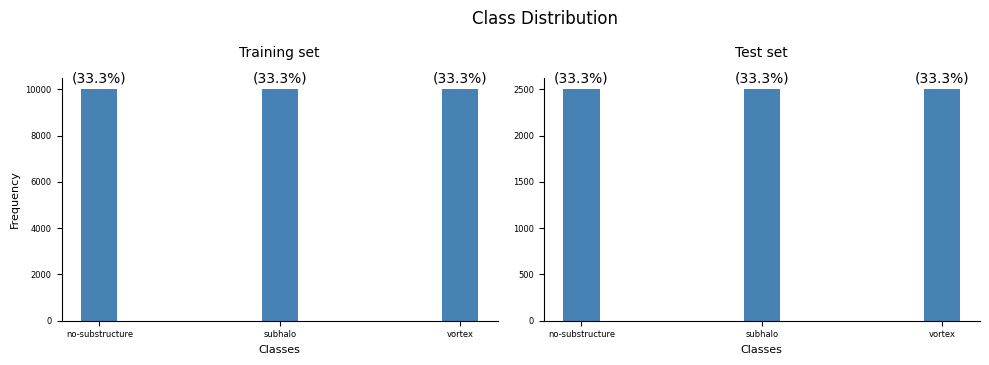

In [5]:
utils.plot_class_distributions(
    dataloaders=(full_train_dataloader, test_dataloader),
    dataloader_names=('Training', 'Test'),
    class_names=['no-substructure', 'subhalo', 'vortex'],
)

### Model

As ResNet18 was originally designed to process the ImageNet dataset, we need to adapt the first and last layer of the PyTorch implementation.
Let us define the following method to instantiate our model.

In [6]:
def get_model() -> nn.Module:
    model = resnet.resnet18()
    model.conv1 = nn.Conv2d(i_c, 64, kernel_size=7, stride=2, padding=3, bias=False) # modify input convolution to process <i_c>-channel inputs
    model.fc = nn.Linear(in_features=512, out_features=N_CLASSES, bias=True) # modify output fully-connected layer to predict <N_CLASSES>
    
    return model

## Model Selection

Model selection is carried out via grid-search, as the search space is not excessively large. We leverage the $80-20$ train-val split obtained from the original training set. In particular, different hyperparamaters' configurations will be trained on the training split and tested on the validation split.

We employ an $Adam$ optimizer with PyTorch default momentum values, and a linear decay learning rate scheduler. An early-stopping mechanism is employed so that training may be stopped when performance on the validation set stops improving for a number of epochs specified by $patience$. 

Training is performed for a maximum number of $100$ epochs, with patience value of $10$. Results are averaged across $5$ different trials.

In [7]:
# Wandb settings
PROJECT_ENTITY = 'gsoc'
MODEL_NAME = 'resnet18'
wandb_project_name = f'{MODEL_NAME}-{DATASET_NAME.lower()}'

In [8]:
grid_search_configs = {
    'apply_sqrt_stretch': {
        'values': [STRETCH]
    },
    'optimizer': {
        'values': ['Adam']
    },
    'lr': {
        'values': [1e-02, 5e-02, 1e-03, 5e-03, 1e-04]
    },
    'lr_decay': {
        'values': [1e-04, 5e-04, 1e-05, 5e-05, 1e-06]
    },
    'trial_id': {
        'values': [1, 2, 3, 4, 5]
    },
}

tuner = tuning.Tuner(
    device=device,
    project_name=wandb_project_name,
    project_entity=PROJECT_ENTITY,
    model_fn=get_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    configs=grid_search_configs,
    epochs=100,
    patience=10,
)
#sweep_id = tuner.run(method='grid') # uncomment if you wish to repeat model selection

## Training

Once the best configuration has been selected via model selection, we perform a final retraining on the entire training set and assess model performance on the test set.

Since we want the evaluation on the test set to be "blind," we cannot use it to perform early stopping. Therefore, the value of $patience$ is set to $None$. To determine a good amount of training epochs when early-stopping cannot be employed,we compute the average epoch on which the best validation performance was achieved during model selection for the current hyperparameters' configuration, and use that as the number of training epochs for the final retraining.

In [9]:
# Best configuration found during model selection
hparams = {
    'apply_sqrt_stretch': True,
    'lr': 0.001,
    'lr_decay': 1e-06 
}

In [10]:
# Create the model
model = get_model()

# Training
solver = Solver(
    device=device,
    model=model,
    train_dataloader=full_train_dataloader,
    val_dataloader=test_dataloader,
    lr=hparams['lr'],
    lr_decay=hparams['lr_decay']
)
#solver.train(epochs=50, log=False) # uncomment if you wish to train a new model

In [11]:
# Store model weights at the last epoch
#outf = f'weights/{DATASET_NAME}/weights.pth'
#print(f"Model weights saved to... {outf}")
#torch.save(solver.model.state_dict(), outf)

## Testing

Let us load the previously saved model weights. Then, we evaluate the model on the test set.

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

# Load model weights
model = get_model()
model.load_state_dict(torch.load(f'weights/{DATASET_NAME}/weights.pth', weights_only=True))

# Predict on the test set
model.to(device)
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():  # Add this to prevent gradient calculation during validation
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        all_labels.extend(labels.cpu().numpy())
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
        all_preds.append(probs)

all_labels = np.array(all_labels)
all_preds = np.vstack(all_preds)
n_classes = all_preds.shape[1]

Below we visualize the performance obtained on the test set. In particular, the classification report gives us in-depth insights into how the models performs on each class.

In [13]:
test_auc = roc_auc_score(all_labels, all_preds, multi_class='ovr', average='macro')
print(f"Test AUC: {test_auc:.4f}")
print(classification_report(all_labels, np.argmax(all_preds, axis=1)))

Test AUC: 0.9798
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2500
           1       0.90      0.84      0.87      2500
           2       0.94      0.87      0.91      2500

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500



Finally, we plot the ROC curve (left), and a confusion matrix (right).

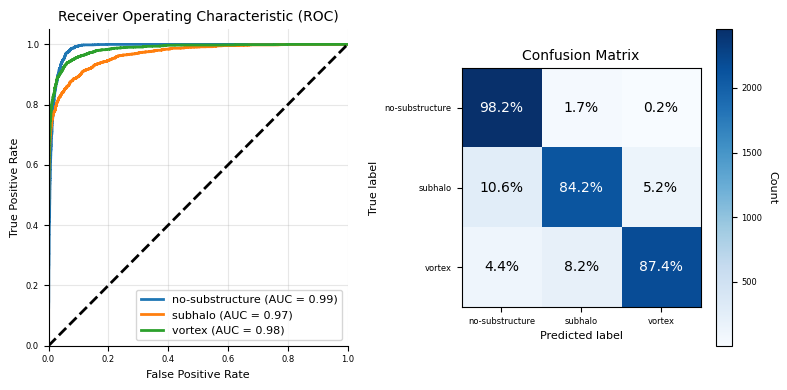

In [14]:
utils.plot_predictions(all_labels, all_preds, ['no-substructure', 'subhalo', 'vortex'])